# 时域图绘制工具

根据输入的CSV文件路径，自动检测表头中的DE、FE、BA字段，并绘制相应数量的时域图。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
from math import pi
from matplotlib import rcParams
import os
from pathlib import Path

# 设置中文字体
def setup_chinese_font():
    """
    设置matplotlib支持中文显示的字体
    """
    # 常见的中文字体列表
    chinese_fonts = [
        'SimHei', 'Microsoft YaHei', 'PingFang SC', 'Heiti TC', 
        'STHeiti', 'Arial Unicode MS', 'WenQuanYi Micro Hei',
        'Noto Sans CJK SC', 'Source Han Sans CN', 'DejaVu Sans'
    ]
    
    available_fonts = []
    
    # 检测可用的中文字体
    for font_name in chinese_fonts:
        try:
            font_path = fm.findfont(font_name, fallback_to_default=False)
            available_fonts.append(font_name)
            print(f"✅ 找到可用中文字体: {font_name}")
        except:
            continue
    
    if available_fonts:
        # 设置字体回退列表，确保中文字体能正常显示
        plt.rcParams['font.sans-serif'] = available_fonts
        plt.rcParams['axes.unicode_minus'] = False
        print(f"✅ 成功设置中文字体: {available_fonts}")
        return True
    else:
        print("⚠️ 警告：未找到可用的中文字体，图表中的中文可能无法正常显示")
        return False

# 设置图表样式（不覆盖中文字体）
def set_chart_style():
    """
    设置图表样式，保留中文字体设置
    """
    # 保存当前字体设置
    current_font = plt.rcParams.get('font.sans-serif', [])
    
    # 设置字体大小
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 12
    
    # 线条宽度
    plt.rcParams['lines.linewidth'] = 1.0
    plt.rcParams['axes.linewidth'] = 0.5
    
    # 图表尺寸
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.rcParams['figure.dpi'] = 100
    
    # 其他样式设置
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['savefig.pad_inches'] = 0.05
    plt.rcParams['savefig.dpi'] = 300
    
    # 恢复中文字体设置
    if current_font:
        plt.rcParams['font.sans-serif'] = current_font

# 设置图表样式
plt.style.use('seaborn-v0_8')

# 首先设置中文字体
setup_chinese_font()

# 然后设置其他图表样式
set_chart_style()

✅ 找到可用中文字体: Heiti TC
✅ 找到可用中文字体: STHeiti
✅ 找到可用中文字体: Arial Unicode MS
✅ 找到可用中文字体: DejaVu Sans
✅ 成功设置中文字体: ['Heiti TC', 'STHeiti', 'Arial Unicode MS', 'DejaVu Sans']


In [2]:
def plot_time_domain_graphs(file_path, max_points=10000):
    """
    根据CSV文件绘制时域图
    
    参数:
    file_path (str): CSV文件路径
    max_points (int): 最大显示数据点数，避免图表过于密集
    """
    try:
        # 读取CSV文件
        df = pd.read_csv(file_path)
        
        # 获取列名
        columns = df.columns.tolist()
        
        print(f"文件: {file_path}")
        print(f"数据形状: {df.shape}")
        print(f"列名: {columns}")
        
        # 检测包含DE、FE、BA的列
        de_cols = [col for col in columns if 'DE_time' in col]
        fe_cols = [col for col in columns if 'FE_time' in col]
        ba_cols = [col for col in columns if 'BA_time' in col]
        
        # 获取RPM列
        rpm_cols = [col for col in columns if 'RPM' in col]
        
        print(f"\n检测到的传感器数据:")
        print(f"DE列: {de_cols}")
        print(f"FE列: {fe_cols}")
        print(f"BA列: {ba_cols}")
        print(f"RPM列: {rpm_cols}")
        
        # 合并所有要绘制的列
        plot_cols = de_cols + fe_cols + ba_cols
        
        if not plot_cols:
            print("\n未找到DE、FE、BA时间序列数据！")
            return
        
        # 创建图表
        n_plots = len(plot_cols)
        fig, axes = plt.subplots(n_plots, 1, figsize=(15, 4 * n_plots))
        
        # 如果只有一个图，将axes转换为列表
        if n_plots == 1:
            axes = [axes]
        
        # 绘制每个传感器数据
        for i, col in enumerate(plot_cols):
            # 获取数据，限制显示点数
            data = df[col].dropna()
            if len(data) > max_points:
                # 均匀采样
                indices = np.linspace(0, len(data)-1, max_points, dtype=int)
                data = data.iloc[indices]
            
            # 创建时间序列（使用索引作为时间）
            time_index = range(len(data))
            
            # 绘制图表
            axes[i].plot(time_index, data, linewidth=0.8)
            axes[i].set_title(f'{col} 时域信号', fontsize=14, fontweight='bold')
            axes[i].set_xlabel('时间点', fontsize=12)
            axes[i].set_ylabel('幅值', fontsize=12)
            axes[i].grid(True, alpha=0.3)
            
            # 如果有RPM数据，显示在标题中
            if rpm_cols and len(df[rpm_cols[0]].dropna()) > 0:
                rpm_value = df[rpm_cols[0]].iloc[0]
                axes[i].set_title(f'{col} 时域信号 (RPM: {rpm_value:.1f})', 
                                fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # 显示数据统计信息
        print("\n数据统计信息:")
        for col in plot_cols:
            col_data = df[col].dropna()
            print(f"\n{col}:")
            print(f"  数据点数: {len(col_data)}")
            print(f"  最大值: {col_data.max():.6f}")
            print(f"  最小值: {col_data.min():.6f}")
            print(f"  均值: {col_data.mean():.6f}")
            print(f"  标准差: {col_data.std():.6f}")
            
    except FileNotFoundError:
        print(f"错误: 文件 '{file_path}' 不存在！")
    except Exception as e:
        print(f"处理文件时发生错误: {e}")
        import traceback
        traceback.print_exc()

文件: 数据集-csv/源域数据集/12kHz_DE_data/B/0007/B007_0.csv
数据形状: (96000, 4)
列名: ['X118_DE_time', 'X118_FE_time', 'X118_BA_time', 'X118RPM']

检测到的传感器数据:
DE列: ['X118_DE_time']
FE列: ['X118_FE_time']
BA列: ['X118_BA_time']
RPM列: ['X118RPM']


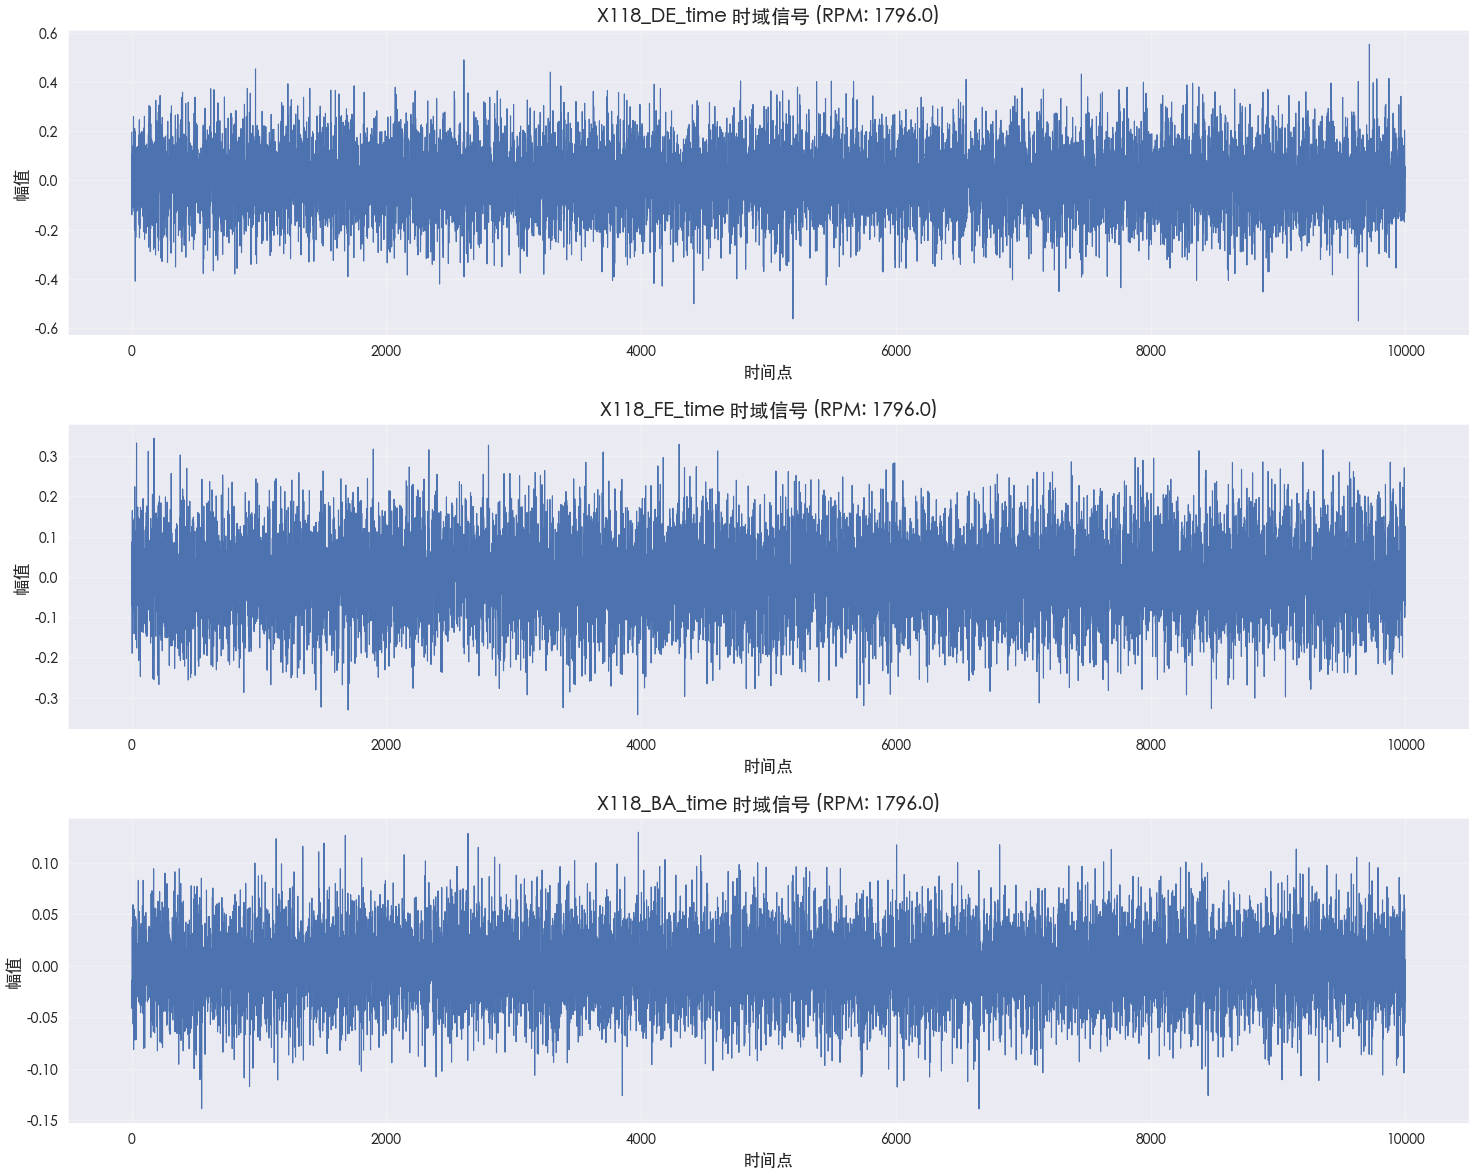


数据统计信息:

X118_DE_time:
  数据点数: 96000
  最大值: 0.579469
  最小值: -0.619627
  均值: 0.000144
  标准差: 0.137791

X118_FE_time:
  数据点数: 96000
  最大值: 0.404867
  最小值: -0.419006
  均值: -0.000010
  标准差: 0.105305

X118_BA_time:
  数据点数: 96000
  最大值: 0.155677
  最小值: -0.159945
  均值: -0.000006
  标准差: 0.035296


In [ ]:
# 使用示例
file_path = "data/源域数据集/12kHz_DE_data/B/0007/B007_0.csv"
plot_time_domain_graphs(file_path)